Best Model's Metric:

*   Classifier: 0.8384157260277698
*   Regressor: 11.468887057194996






In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer

# 1. Data Exploration & Visualization

We have created a better visualization using Tableau for the purpose of Exploratory Analysis. Please visit this [link](https://public.tableau.com/views/PhysioNet/Dashboard1?:display_count=y&:origin=viz_share_link) to acces the Tableau Dashboard. You can even download Tableau Workbook from there.

From the Tableau Dashboard it is very clear that most of the temporal attributes are **very sparse**. Only few temporal attributes like HR, Urine are somewhat dense.

Note: This module requires ***Viz_Data.csv*** file generated by ***Viz_Data_Pipe.ipynb*** from raw data. 

Vizualization for 132539


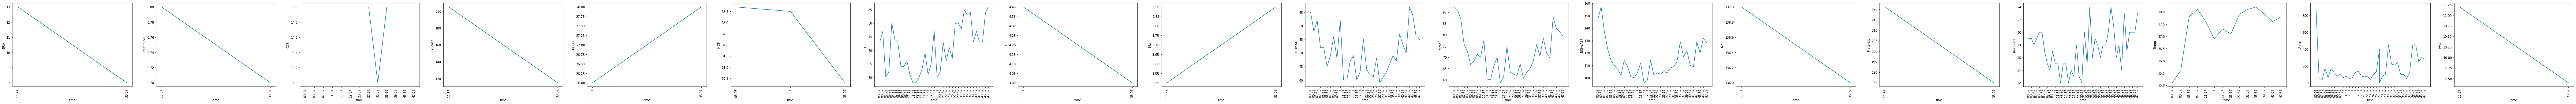

In [0]:
# Enter the path for Viz_Data.csv, rid
viz_file_path = "./Prep_Data/Viz_Data.csv"
rid = 132539

# Read the data into dataframe
viz_df = pd.read_csv(viz_file_path)
rid_df = viz_df.groupby('rid').get_group(rid)

# Count the available number of temporal data for the given rid
# Note: We need atleast two values for a temporial attribute to visualize in lineplot
temp_attr_list = [ "Albumin", "ALP", "ALT", "AST", "Bilirubin", "BUN", "Cholesterol",
                "Creatinine", "DiasABP", "FiO2", "GCS", "Glucose", "HCO3", "HCT",
                "HR", "K", "Lactate", "Mg", "MAP", "MechVent", "Na", "NIDiasABP",
                "NIMAP", "NISysABP", "PaCO2", "PaO2", "pH", "Platelets", 
                "RespRate", "SaO2", "SysABP", "Temp", "TroponinI", "TroponinT",
                "Urine", "WBC"]
no_of_plots = 0
for attr, attr_df in rid_df.groupby('Attr_Name'):
  if (attr_df.shape[0] <= 1) or (attr not in temp_attr_list):
    continue
  no_of_plots += 1

# Plot line graph
fig, axs = plt.subplots(1, no_of_plots)
fig.set_size_inches(150, 5)
current_ax = 0
for attr, attr_df in rid_df.groupby('Attr_Name'):
  if (attr_df.shape[0] <= 1) or (attr not in temp_attr_list):
    continue
  axs[current_ax].plot(attr_df['time'], attr_df['Attr_Value'])
  axs[current_ax].set(xlabel='time', ylabel=attr)
  for tick in axs[current_ax].get_xticklabels():
        tick.set_rotation(90)
  current_ax += 1

print("Vizualization for", rid)

# 2. Feature Engineering

Based on the Exploratory Analysis using Tableau Dashboard, it is very clear that temporal attributes are very sparse. So we decided to use primarily the summary of temporal attributes of each patient instead of actual temporal data. 

Below are the 4 four design matrices that we decided to experiment with.


1.   Temporal_Mean_Matrix (mean_df)
2.   Reduced_Temporal_Mean_Matrix (r_mean_df)
3.   Temporal_Mode_Matrix (mode_df)
4.   Temporal_Mean_Std_Matrix (s_mean_df)



## 2.1. Temporal_Mean_Matrix

In this design matrix, we decided to use **mean value** of temporal data as a feature instead of using raw temporal data. For example if patient X has HR values (hr1, hr2, hr3, hr4) recorded on time (t1, t2, t3, t4), we will consider only the mean(hr1, hr2, hr3, hr4) as feature for patient X. Static data remains unchanged.

Note: This module requires ***summary_mean.csv*** file generated by ***Data_Prep_Pipe.ipynb*** from raw data. *summary_mean.csv* will have patient data in order in such a way that first set of rows will be from fold 1, following that will be fold 2, and so on.

In [0]:
# Enter the path for file summary_mean
mean_file_path = ",/Prep_Data/summary_mean.csv"

mean_df = pd.read_csv(mean_file_path)

# Clean the Data
mean_df['Length_of_stay'].replace(-1, 2, inplace=True)
mean_df['Height'] = mean_df['Height'].apply(lambda x: np.NaN if x == -1.0 else x)
mean_df['Weight'] = mean_df['Weight'].apply(lambda x: np.NaN if x == -1.0 else x)
mean_df['Gender'] = mean_df['Gender'].apply(lambda x:np.NaN if x == -1 else x)

# Drop Record ID
mean_df = mean_df.drop(columns=["RecordID"])

mean_df.head(3)

,Age,Gender,Height,ICUType,Weight,Albumin,ALP,ALT,AST,Bilirubin,BUN,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,MAP,MechVent,Na,NIDiasABP,NIMAP,NISysABP,PaCO2,PaO2,pH,Platelets,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Length_of_stay,In-hospital_death
0,54,0.0,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,10.500000,NaN,0.750000,NaN,NaN,14.923077,160.000000,27.000000,32.500000,70.810811,4.20,NaN,1.70,NaN,NaN,136.500000,50.147059,71.559118,114.382353,NaN,NaN,NaN,203.000000,17.428571,NaN,NaN,37.357143,NaN,NaN,171.052632,10.300000,5,0
1,76,1.0,175.3,2,80.670588,NaN,NaN,NaN,NaN,NaN,18.333333,NaN,1.100000,58.897059,0.56,13.333333,125.500000,22.333333,28.655556,80.794118,3.90,NaN,2.30,76.940299,1.0,137.000000,56.714286,75.308571,112.500000,38.857143,210.142857,7.395,178.600000,NaN,96.833333,113.411765,36.939130,NaN,NaN,151.560976,11.266667,8,0
2,44,0.0,NaN,3,56.700000,2.5,116.0,83.0,199.5,2.9,4.666667,NaN,0.333333,67.125000,0.50,5.923077,134.333333,25.000000,28.460000,83.759259,4.26,1.366667,1.72,90.437500,1.0,138.333333,79.000000,96.751316,132.263158,35.500000,134.500000,7.495,89.666667,NaN,95.000000,125.687500,37.800000,NaN,NaN,124.951220,4.700000,19,0


## 2.2. Reduced_Temporal_Mean_Matrix

Feature selection is done explicitly to reduce the size of Temporal_Mean_Matrix to get new Matrix. We are dropping features based on correlation, sparsity in values and constant variables.

Removed Columns: ['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'Cholesterol', 'RespRate', 'SaO2', 'TroponinI', 'TroponinT', 'MechVent', 'NIMAP']


,Age,Gender,Height,ICUType,Weight,BUN,Creatinine,DiasABP,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,MAP,Na,NIDiasABP,NIMAP,NISysABP,PaCO2,PaO2,pH,Platelets,SysABP,Temp,Urine,WBC,Length_of_stay,In-hospital_death
0,54,0.0,NaN,4,NaN,10.500000,0.750000,NaN,NaN,14.923077,160.000000,27.000000,32.500000,70.810811,4.20,NaN,1.70,NaN,136.500000,50.147059,71.559118,114.382353,NaN,NaN,NaN,203.000000,NaN,37.357143,171.052632,10.300000,5,0
1,76,1.0,175.3,2,80.670588,18.333333,1.100000,58.897059,0.56,13.333333,125.500000,22.333333,28.655556,80.794118,3.90,NaN,2.30,76.940299,137.000000,56.714286,75.308571,112.500000,38.857143,210.142857,7.395,178.600000,113.411765,36.939130,151.560976,11.266667,8,0
2,44,0.0,NaN,3,56.700000,4.666667,0.333333,67.125000,0.50,5.923077,134.333333,25.000000,28.460000,83.759259,4.26,1.366667,1.72,90.437500,138.333333,79.000000,96.751316,132.263158,35.500000,134.500000,7.495,89.666667,125.687500,37.800000,124.951220,4.700000,19,0


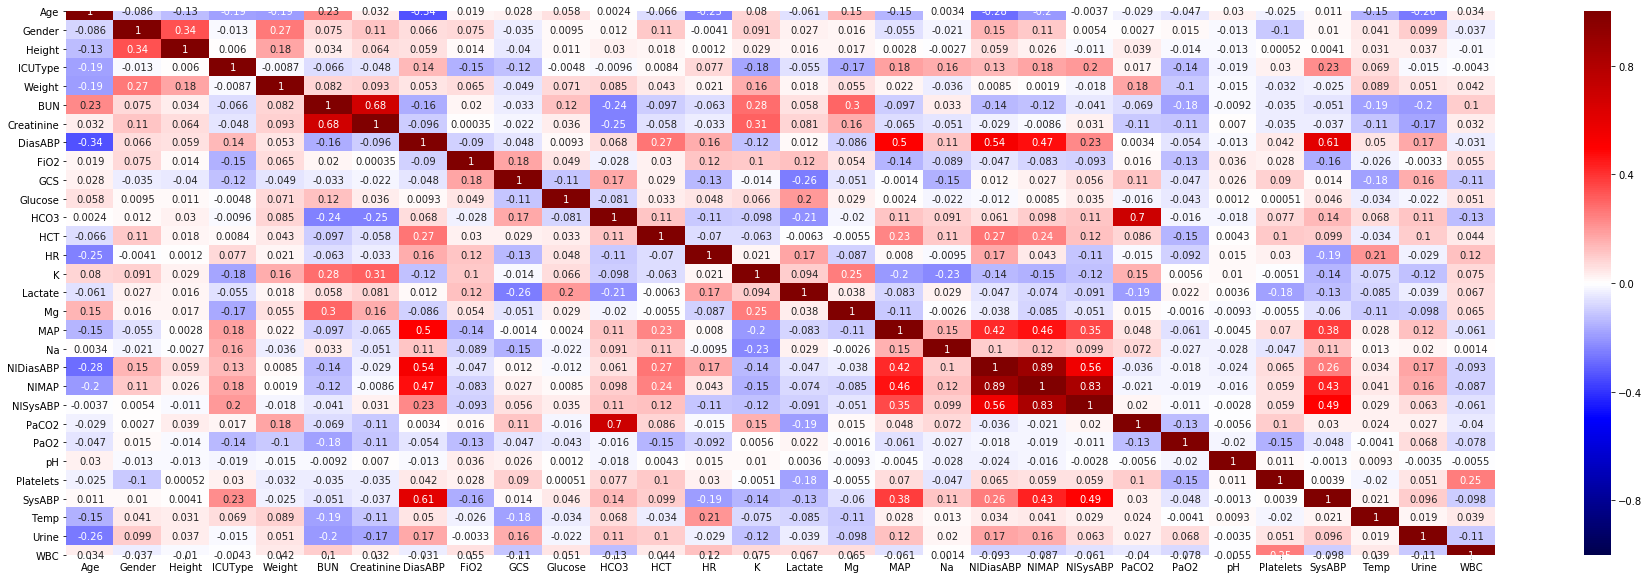

In [0]:
# Columns to be dropped
drop_cols = []

# Drop sparse features - Drop features if more than half of the patients doesn't have data
for items in mean_df.isna().sum().iteritems(): 
    if items[1] > 2000:
      drop_cols.append(items[0])

# Drop constant features and impute remaining features - Based on Exploratory Analysis
drop_cols.append('MechVent')

# Create new matrix and impute remaining features
r_mean_df = mean_df.drop(columns=drop_cols)

# Remove highly correlated features
X = r_mean_df.drop(columns=["Length_of_stay","In-hospital_death"])
plt.figure(figsize=(32,10))
sns.heatmap(data=X.corr(), cmap='seismic',annot=True, vmin=-1, vmax=1)
drop_cols.append("NIMAP") # NIMAP is highly correalted to NIDiasABP, NISysABP
r_mean_df.drop(columns=['NIMAP'])

print("Removed Columns:", drop_cols)
r_mean_df.head(3)

## 2.3. Temporal_Mode_Matrix

In this design matrix, we decided to use **mode value** of temporal data as a feature instead of using raw temporal data. For example if patient X has HR values (hr1, hr2, hr3, hr4) recorded on time (t1, t2, t3, t4), we will consider only the mode(hr1, hr2, hr3, hr4) as feature for patient X. Static data remains unchanged.

Note: This module requires ***summary_mode.csv*** file generated by ***Data_Prep_Pipe.ipynb*** from raw data. *summary_mode.csv* will have patient data in order in such a way that first set of rows will be from fold 1, following that will be fold 2, and so on.

In [0]:
# Enter the path for file summary_mode
mode_file_path = "./Prep_Data/summary_mode.csv"

mode_df = pd.read_csv(mode_file_path)

# Clean the Data
mode_df['Length_of_stay'].replace(-1, 2, inplace=True)
mode_df['Height'] = mode_df['Height'].apply(lambda x: np.NaN if x == -1.0 else x)
mode_df['Weight'] = mode_df['Weight'].apply(lambda x: np.NaN if x == -1.0 else x)
mode_df['Gender'] = mode_df['Gender'].apply(lambda x:np.NaN if x == -1 else x)

# Drop Record ID
mode_df = mode_df.drop(columns=["RecordID"])

mode_df.head(3)

,Age,Gender,Height,ICUType,Weight,Albumin,ALP,ALT,AST,Bilirubin,BUN,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,MAP,MechVent,Na,NIDiasABP,NIMAP,NISysABP,PaCO2,PaO2,pH,Platelets,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Length_of_stay,In-hospital_death
0,54,0.0,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,0.7,NaN,NaN,15.0,115.0,26.0,30.3,73.0,4.0,NaN,1.5,NaN,NaN,136.0,40.0,63.33,104.0,NaN,NaN,NaN,185.0,20.0,NaN,NaN,37.6,NaN,NaN,80.0,9.4,5,0
1,76,1.0,175.3,2,80.6,NaN,NaN,NaN,NaN,NaN,16.0,NaN,0.8,57.0,0.4,15.0,105.0,21.0,28.8,80.0,3.5,NaN,1.9,80.0,1.0,135.0,38.0,70.33,115.0,34.0,82.0,7.4,135.0,NaN,97.0,118.0,37.5,NaN,NaN,50.0,7.4,8,0
2,44,0.0,NaN,3,56.7,2.3,105.0,75.0,164.0,2.8,3.0,NaN,0.3,65.0,0.5,5.0,119.0,24.0,26.7,78.0,2.3,0.9,1.9,83.0,1.0,137.0,84.0,103.00,127.0,37.0,65.0,7.5,72.0,NaN,95.0,103.0,37.2,NaN,NaN,100.0,3.7,19,0


## 2.4. Temporal_Mean_Std_Matrix

In this design matrix, we decided to use **mean value** of temporal data as a feature instead of using raw temporal data. Along with the mean value we will also use **standard deviation** of few attributes that doesn't suffer from sparsity problem like HR, Urine etc. We are doing this to better summarize the temporal data. 

Here is the list of attributes for which standard deviation is taken into consideration. We decided this list based on the average number of observations found for a temporal attribute. This metric can be found in Tableau Dashboard.

['DiasABP', 'FiO2', 'GCS', 'HR', 'MAP','NIDiasABP','NIMAP','SysABP','Temp','Urine', 'Weight']. 

Note: This module requires ***combined_mean_std.csv*** file generated by ***Data_Prep_Pipe.ipynb*** from raw data. *combined_mean_std.csv* will have patient data in order in such a way that first set of rows will be from fold 1, following that will be fold 2, and so on.

In [0]:
# Enter the path for file summary_stddev
s_mean_file_path = "./Prep_Data/combined_mean_std.csv"

s_mean_df = pd.read_csv(s_mean_file_path)

# Clean the Data
s_mean_df['Length_of_stay'].replace(-1, 2, inplace=True)
s_mean_df['Height'] = s_mean_df['Height'].apply(lambda x: np.NaN if x == -1.0 else x)
s_mean_df['Weight'] = s_mean_df['Weight'].apply(lambda x: np.NaN if x == -1.0 else x)
s_mean_df['Gender'] = s_mean_df['Gender'].apply(lambda x:np.NaN if x == -1 else x)

# Drop Record ID
s_mean_df = s_mean_df.drop(columns=["RecordID"])

s_mean_df.head(3)

,Age,Gender,Height,ICUType,Weight,Albumin,ALP,ALT,AST,Bilirubin,BUN,Cholesterol,Creatinine,DiasABP,FiO2,GCS,Glucose,HCO3,HCT,HR,K,Lactate,Mg,MAP,MechVent,Na,NIDiasABP,NIMAP,NISysABP,PaCO2,PaO2,pH,Platelets,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Length_of_stay,In-hospital_death,DiasABP_std,FiO2_std,GCS_std,HR_std,MAP_std,NIDiasABP_std,NIMAP_std,SysABP_std,Temp_std,Urine_std,Weight_std
0,54,0.0,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,10.500000,NaN,0.750000,NaN,NaN,14.923077,160.000000,27.000000,32.500000,70.810811,4.20,NaN,1.70,NaN,NaN,136.500000,50.147059,71.559118,114.382353,NaN,NaN,NaN,203.000000,17.428571,NaN,NaN,37.357143,NaN,NaN,171.052632,10.300000,5,0,NaN,NaN,0.277350,8.605030,NaN,7.977743,9.260921,NaN,0.935385,171.870307,-1.000000
1,76,1.0,175.3,2,80.670588,NaN,NaN,NaN,NaN,NaN,18.333333,NaN,1.100000,58.897059,0.56,13.333333,125.500000,22.333333,28.655556,80.794118,3.90,NaN,2.30,76.940299,1.0,137.000000,56.714286,75.308571,112.500000,38.857143,210.142857,7.395,178.600000,NaN,96.833333,113.411765,36.939130,NaN,NaN,151.560976,11.266667,8,0,7.188589,0.250998,3.265986,6.739411,9.800867,9.918348,11.359293,16.338979,0.986234,161.509760,0.920978
2,44,0.0,NaN,3,56.700000,2.5,116.0,83.0,199.5,2.9,4.666667,NaN,0.333333,67.125000,0.50,5.923077,134.333333,25.000000,28.460000,83.759259,4.26,1.366667,1.72,90.437500,1.0,138.333333,79.000000,96.751316,132.263158,35.500000,134.500000,7.495,89.666667,NaN,95.000000,125.687500,37.800000,NaN,NaN,124.951220,4.700000,19,0,8.655441,0.151911,1.187542,11.536546,9.359265,7.263385,7.379448,12.153017,0.642112,93.216670,0.000000


# 3. Model Building

## 3.1. Model 1 - Mortality Classification 

For classification task, we experiemented with different classifiers, feature selection methods, and dimensionality reduction methods. Few of those includes SelectKBest, VarianceThreshold, Truncated SVD, Logistic Regression, LinearSVC, DecisionTree Classifier, RandomForest Classifier, XGBoost Classifier, etc. To do hyperparameter tuning, we used GridSearchCV. Below we are presenting the best model that we got from our experimentation. Below model works well for most of the our design matrices.

In [0]:
def classifier_one(df, matrix_name):

  X = df.drop(columns=["Length_of_stay","In-hospital_death"])
  y = df["In-hospital_death"]

  num_cols = [e for e in list(X.columns) if e not in ('Gender', 'ICUType')]

  # Preprocessor - Imputation and Scaling
  numeric_transformer = Pipeline(steps=[
      ('num_imputer', SimpleImputer(missing_values=np.NaN,strategy='mean')),
      ('scaler', StandardScaler())])
  non_numeric_transformer = Pipeline(steps=[
      ('non_num_imputer', SimpleImputer(missing_values=np.NaN,strategy='most_frequent'))])
  preprocessor = ColumnTransformer(
      transformers=[
          ('numeric', numeric_transformer, num_cols),
          ('non_numeric', non_numeric_transformer, ['Gender', 'ICUType'])])

  Model1 = Pipeline(steps=[('preprocessing', preprocessor),
                          ('pca',TruncatedSVD()),
                          ('xgb',XGBClassifier(gamma=1, learning_rate=0.1, max_depth=3, subsample=0.9))])

  scores = cross_val_score(Model1, X, y, cv = KFold(n_splits=4, shuffle=False), scoring="roc_auc")
  print(matrix_name+":", sum(scores)/len(scores))

classifier_one(mean_df, "Temporal_Mean_Matrix")
classifier_one(r_mean_df, "Reduced_Temporal_Mean_Matrix")
classifier_one(mode_df, "Temporal_Mode_Matrix")
classifier_one(s_mean_df, "Temporal_Mean_Std_Matrix")

Temporal_Mean_Matrix: 0.6936700483350594
Reduced_Temporal_Mean_Matrix: 0.6736728159491939
Temporal_Mode_Matrix: 0.695218876427008
Temporal_Mean_Std_Matrix: 0.6789415313106031


## 3.2. Model 1 - LoS Regression

For regression task, we experiemented with different regressors, feature selection methods, and dimensionality reduction methods. Few of those includes SelectKBest, Truncated SVD, Linear Regression, SVR, kNN, regressor, Ridge, Lasso, ElasticNet,HuberRegressor, DecisionTree, Regressor, MLP Regressor, xgboost, randomforestregressor, etc. To do hyperparameter tuning, we used GridSearchCV. Below we are presenting the best model that we got from our experimentation. Below model works well for most of the our design matrices.

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def rmse(y, y_pred):
        return np.sqrt(np.mean((y_pred - y)**2))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

def regressor_one(df, matrix_name):

  X = df.drop(columns=["Length_of_stay","In-hospital_death"])
  y = df["Length_of_stay"]

  num_cols = [e for e in list(X.columns) if e not in ('Gender', 'ICUType')]

  # Preprocessor - Imputation and Scaling
  numeric_transformer = Pipeline(steps=[
      ('num_imputer', SimpleImputer(missing_values=np.NaN,strategy='mean')),
      ('scaler', StandardScaler())])
  non_numeric_transformer = Pipeline(steps=[
      ('non_num_imputer', SimpleImputer(missing_values=np.NaN,strategy='most_frequent'))])
  preprocessor = ColumnTransformer(
      transformers=[
          ('numeric', numeric_transformer, num_cols),
          ('non_numeric', non_numeric_transformer, ['Gender', 'ICUType'])])

  Model1 = Pipeline(steps=[('preprocessing', preprocessor),
                           ('pca',TruncatedSVD()),
                           ('xgb', xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 40, max_depth = 5))])

  scores = cross_val_score(Model1, X, y, cv = KFold(n_splits=4, shuffle=False), scoring=rmse_scorer)
  print(matrix_name+":", -1 * sum(scores)/len(scores))

import xgboost as xgb

regressor_one(mean_df, "Temporal_Mean_Matrix")
regressor_one(r_mean_df, "Reduced_Temporal_Mean_Matrix")
regressor_one(mode_df, "Temporal_Mode_Matrix")
regressor_one(s_mean_df, "Temporal_Mean_Std_Matrix")

Temporal_Mean_Matrix: 12.02256067547578
Reduced_Temporal_Mean_Matrix: 12.089102799765893
Temporal_Mode_Matrix: 12.210197836803625
Temporal_Mean_Std_Matrix: 12.097342391776749


## 3.3. Model 2

From our experiementation, it is very clear that reducing the number of features explicitly or implicitly doesn't improve the model much. So we decided to remove the dimensionality reduction completely. This lead to a drastic improvement in the resulting model.

In [0]:
# Improved Mortality Classifier
def classifier_two(df, model_name):

  X = df.drop(columns=["Length_of_stay","In-hospital_death"])
  y = df["In-hospital_death"]

  num_cols = [e for e in list(X.columns) if e not in ('Gender', 'ICUType')]

  # Preprocessor - Imputation and Scaling
  numeric_transformer = Pipeline(steps=[
      ('num_imputer', SimpleImputer(missing_values=np.NaN,strategy='mean')),
      ('scaler', StandardScaler())])
  non_numeric_transformer = Pipeline(steps=[
      ('non_num_imputer', SimpleImputer(missing_values=np.NaN,strategy='most_frequent'))])
  preprocessor = ColumnTransformer(
      transformers=[
          ('numeric', numeric_transformer, num_cols),
          ('non_numeric', non_numeric_transformer, ['Gender', 'ICUType'])])

  Model1 = Pipeline(steps=[('preprocessing', preprocessor),
                          ('xgb',XGBClassifier(gamma=1, learning_rate=0.1, max_depth=3, subsample=0.9))])

  scores = cross_val_score(Model1, X, y, cv = KFold(n_splits=4, shuffle=False), scoring="roc_auc")
  print(model_name+":", sum(scores)/len(scores))

# Improved LoS Regressor
def regressor_two(df, model_name):

  X = df.drop(columns=["Length_of_stay","In-hospital_death"])
  y = df["Length_of_stay"]

  num_cols = [e for e in list(X.columns) if e not in ('Gender', 'ICUType')]

  # Preprocessor - Imputation and Scaling
  numeric_transformer = Pipeline(steps=[
      ('num_imputer', SimpleImputer(missing_values=np.NaN,strategy='mean')),
      ('scaler', StandardScaler())])
  non_numeric_transformer = Pipeline(steps=[
      ('non_num_imputer', SimpleImputer(missing_values=np.NaN,strategy='most_frequent'))])
  preprocessor = ColumnTransformer(
      transformers=[
          ('numeric', numeric_transformer, num_cols),
          ('non_numeric', non_numeric_transformer, ['Gender', 'ICUType'])])

  Model1 = Pipeline(steps=[('preprocessing', preprocessor),
                           ('xgb', xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 40, max_depth = 5))])

  scores = cross_val_score(Model1, X, y, cv = KFold(n_splits=4, shuffle=False), scoring=rmse_scorer)
  print(model_name+":", -1 * sum(scores)/len(scores))

classifier_two(mean_df, "Classifier Model 2")
regressor_two(mode_df, "Regressor Model 2")

Classifier Model 2: 0.8384157260277698
Regressor Model 2: 11.468887057194996


# 4. Deployment Workflow

## 4.1. Workflow

![alt text](https://i.ibb.co/tMMD130/Intelligent-system-prj-wrkflow.jpg)

**Step 1:** Get Mean Summary, Mode Summary - Refer to Section 2.1, 2.3.

**Step 2:** Clean Data - Replace '-1' missing values to 'np.NaN' for both Mean Summary, Mode Summary - Refer to Section 2.1, 2.3. Do Preprocessor following that for both summary - Refer to Section 3.3. Preprocessor includes Imputation, Scaling.

**Step 3:** Use mean summary as input for best classifier and use mode summary as input for best regressor - Refer Section 3.3.

Image Src. Local Path: ./Images/workflow.jpeg


## 4.2. Analysing the sensitivity-specificity requirements

![alt text](https://i.ibb.co/HYpwCNx/1-y-F8hv-KR9e-Nfqqej2-Jn-VKzg.png)

Red distribution curve is of the positive class and green distribution curve is of negative class. AUC is 0.83, it means there is 83% chance that model will be able to distinguish between positive class and negative class.

When we decrease the threshold, we get more positive values thus it increases the sensitivity and decreasing the specificity. Similarly, when we increase the threshold, we get more negative values thus we get higher specificity and lower sensitivity.

Image Ref.: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

Image Src. Local Path: ./Images/auc.png